# 附录：条件波动率和经验波动率

In [1]:
def cal_vol_from_Diebolda(df_high, df_low):
    """
    计算diebolda波动率
    """
    df_vol_better =  0.361 * (np.log(df_high) - np.log(df_low)) ** 2
    return (100 * np.sqrt(df_vol_better  * 365))


### 日内波动率的计算

In [1]:
#波动率={0.511*（H-L）2-0.019*[（C-O）（H+L-2*O）-2*（H-O）*(L-O)]-0.383*(C-O)2}1/2
#其中H、L、O和C分别表示最高价、最低价、开盘价和收盘价。从计算的波动率时间序列来看，与VIX指数走势基本一致。
def calculate_intral_volatility(open_, high, low, close):
    term1 = 0.511 * (high - low) ** 2
    term2 = -0.019 * ((close - open_) * (high + low - 2 * open_) - 2 * (high - open_) * (low - open_))
    term3 = -0.383 * (close - open_) ** 2
    #print (term1 + term2)
    volatility = np.sqrt(term1 + term2 + term3)
    return volatility

In [2]:
import pandas as pd
close_df = pd.read_csv('datasets/processed_data/close.csv')
close_df.index = close_df['time']
close_df = close_df.iloc[:, 1:]

open_df = pd.read_csv('datasets/processed_data/open.csv')
open_df.index = open_df['time']
open_df = open_df.iloc[:, 1:]

high_df = pd.read_csv('datasets/processed_data/high.csv')
high_df.index = high_df['time']
high_df = high_df.iloc[:, 1:]

low_df = pd.read_csv('datasets/processed_data/low.csv')
low_df.index = low_df['time']
low_df = low_df.iloc[:, 1:]
close_df.shape

(3504, 2212)

In [3]:
import numpy as np
vol_interday = calculate_intral_volatility(open_df, high_df, low_df, close_df)
vol_interday = vol_interday.ffill()
# 控制缺失值的数量
vol_interday = vol_interday.loc[:, (vol_interday.isnull().sum()>500) == False].dropna()
vol_interday.shape

/Users/xhc/miniconda3/envs/d2l/lib/python3.11/site-packages/pandas/core/internals/blocks.py:393: RuntimeWarning: invalid value encountered in sqrt
  result = func(self.values, **kwargs)


(3007, 2212)

In [12]:
vol_interday.to_csv('vol_interday.csv')

In [5]:
vol_cond = pd.read_csv('datasets/processed_data/conditional_vol.csv', index_col=0)

In [6]:
vol_cond.shape

(3006, 2212)

In [7]:
df = pd.DataFrame(vol_interday.mean(), columns=['vol_interday'])
df['vol_cond'] = vol_cond.mean()
df

,vol_interday,vol_cond
000001,22.781253,2.030806
000002,54.917648,2.270816
000004,4.364469,3.071209
000005,0.799437,2.373780
000006,7.342952,2.525693
...,...,...
601991,0.171858,1.997373
601992,0.158343,2.239497
601996,0.331205,2.480986
601998,0.118209,1.708615


In [8]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
import statsmodels.api as sm

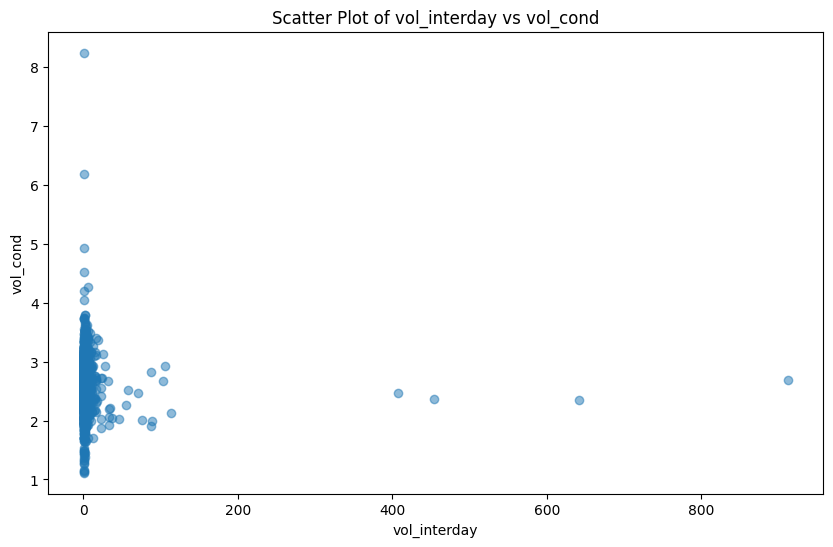

In [9]:
# df.plot(kind='scatter', x='Volatility', y='ESG_Score')
plt.figure(figsize=(10, 6))
plt.scatter(df['vol_interday'], df['vol_cond'], alpha=0.5)
plt.title('Scatter Plot of vol_interday vs vol_cond')
plt.xlabel('vol_interday')
plt.ylabel('vol_cond')
plt.show()

In [18]:
# 计算皮尔逊相关系数
corr, p_value = pearsonr(df['vol_interday'], df['vol_cond'])
print(f"Pearson correlation coefficient: {corr:.4f}, P-value: {p_value:.4f}")

Pearson correlation coefficient: -0.0249, P-value: 0.2418


In [19]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
import statsmodels.api as sm

X = df['vol_interday']
y = df['vol_cond']
X = sm.add_constant(X)  # 添加常数项
model = sm.OLS(y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:               vol_cond   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     1.371
Date:                Tue, 16 Jul 2024   Prob (F-statistic):              0.242
Time:                        17:26:05   Log-Likelihood:                -1132.3
No. Observations:                2212   AIC:                             2269.
Df Residuals:                    2210   BIC:                             2280.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const            2.6566      0.009    307.007   